# Bootcamp Geração Tech Unimed - BH | Desafio de projeto - DIO | Transfer Learning para classificação de imagens:

In [46]:
#importação das bibliotecas:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import random
import zipfile
import cv2 as cv2
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from google.colab import drive

In [3]:
#verificando a versão do tensorflow:

tf.__version__

'2.9.2'

In [5]:
#conectando o notebook ao Google Drive:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#extraindo as imagens, que servirão para o treinamento, do arquivo .zip:

path = '/content/drive/MyDrive/colab_notebooks/cat_dog.zip' #determina o caminho do arquivo

zip_object = zipfile.ZipFile(file = path, mode = 'r') 
zip_object.extractall('/content/drive/MyDrive/colab_notebooks/')

zip_object.close()

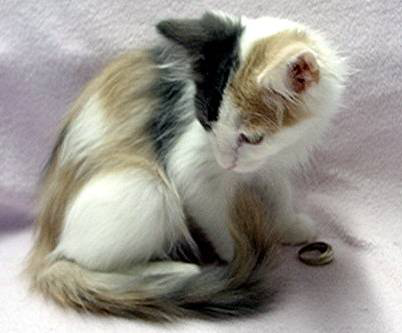

In [6]:
#visualizando uma das imagens da pasta concernente aos gatos:

tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/cat/cat.3500.jpg')

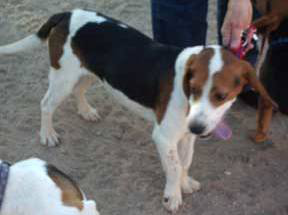

In [7]:
#visualizando uma das imagens da pasta concernente aos cachorros:

tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/dog/dog.3500.jpg')

In [8]:
#redimensionando as imagens e normalizando o conjunto de treinamento:

trainer_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 7, horizontal_flip = True, zoom_range = 0.2)

trainer_dataset = trainer_generator.flow_from_directory('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/', target_size = (128, 128), batch_size = 128,
                                                        class_mode = 'categorical', shuffle = True)

Found 1000 images belonging to 2 classes.


In [9]:
#alterando, respectivamente, a rotação, a orientação, o zoom e o brilho das imagens:

datagenerator = ImageDataGenerator(rotation_range = 7, #alterando a rotação
                                   horizontal_flip = True, #alterando a orientação
                                   zoom_range = 0.2, #alterando o zoom
                                   brightness_range = [0.2, 1.2] #alterando o brilho
                                   )

In [10]:
#imagens sem alterações:

datanorm = ImageDataGenerator()

In [11]:
#conjunto contendo todas as alterações:

changed_train = datagenerator.flow_from_directory('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/', target_size = (400, 400), #padronizando o tamanho das imagens
                                                  color_mode = 'rgb', #definindo imagens coloridas
                                                  batch_size = 1, #quantidade de imagens extraídas por batch
                                                  class_mode = 'binary', #definindo modo das classes
                                                  seed = 2020)

Found 1000 images belonging to 2 classes.


In [12]:
#conjunto de imagens inalteradas:

normal_train = datanorm.flow_from_directory('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/', target_size = (400, 400),
                                            color_mode = 'rgb',
                                            batch_size = 1,
                                            class_mode = 'binary',
                                            seed = 2020)

Found 1000 images belonging to 2 classes.


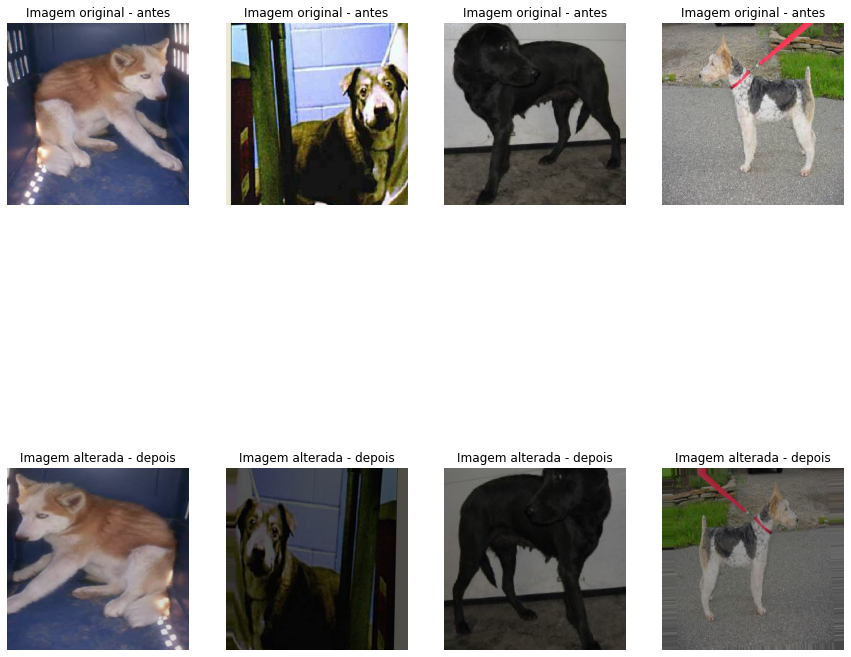

In [13]:
#plotando as imagens:

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (15, 15))

for i in range (4): 
  #convertendo imagens para valores inteiros
  image = next(changed_train)[0].astype('uint8')
  image2 = next(normal_train)[0].astype('uint8')

  #alterando o tamanho das imagens de (1, 200, 200, 3) para (200, 200, 3)
  image = np.squeeze(image)
  image2 = np.squeeze(image2)

  #plotando as imagens:
  ax[0, i].imshow(image2)
  ax[0, i].set_title('Imagem original - antes')
  ax[0, i].axis('off')
  ax[1, i].imshow(image)
  ax[1, i].set_title('Imagem alterada - depois')
  ax[1, i].axis('off')

In [14]:
#realizando o redimensionamento/normalização do conjunto de imagens de teste:

test_generator = ImageDataGenerator(rescale = 1./255)

test_dataset = test_generator.flow_from_directory('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/',
                                                  target_size = (128, 128),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 1000 images belonging to 2 classes.


# Transfer Learning:

Será utilizado o modelo 'MobileNetV2' para o processo de transferência de aprendizagem, por meio do qual usaremos os pesos das camadas do modelo previamente treinado e implementaremos apenas as camadas finais para satisfazermos nosso objetivo, que consiste na identificação mais precisa o possível da diferença entre figuras de cães e gatos:

In [15]:
#carregamento do MobileNetV2:

base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
#obtendo as informações sobre as camadas do modelo de base:

base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [17]:
#visualização da quantidade de camadas que o modelo de base possui:

len(base_model.layers)

154

In [18]:
#fixando os pesos das camadas do modelo de treino, para podermos as reaproveitar posteriormente:

for camada in base_model.layers:
  camada.trainable = False

In [19]:
#acessando a última camada do modelo base, a partir da qual adicionaremos a estrutura densa de nosso modelo:

base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [20]:
#construção do modelo de aprendizado:

head_model = base_model.output #acessando a última camada
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model) #combinando os dados
head_model = Dense(641, activation = 'relu')(head_model) #estamos utilizando a metade do total de conexões (1280) + 2, ou seja, 641 conexões para fazer a ligação com a nova camada
head_model = Dropout(0.2)(head_model) #descartando 20% das conexões para a nova camada, afim de reduzir o overfitting
head_modeç = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

# Construção e Treinamento de nossa rede neural:

In [21]:
#conectando o modelo base às camadas que foram implementadas:

network = Model(inputs = base_model.input, outputs = head_model)

In [22]:
#verificando as informações das camadas:

network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [23]:
#verificando quantas camadas temos:

len(network.layers)

159

In [24]:
#compilando o modelo de aprendizagem:

network.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
#realizando o treinamento com 10 épocas:

history = network.fit(trainer_dataset, epochs = 10)

Epoch 1/10
8/8 [==============================] - 180s 21s/step - loss: 0.3471 - accuracy: 0.8640
Epoch 2/10
8/8 [==============================] - 17s 2s/step - loss: 0.1988 - accuracy: 0.9360
Epoch 3/10
8/8 [==============================] - 17s 2s/step - loss: 0.1110 - accuracy: 0.9580
Epoch 4/10
8/8 [==============================] - 19s 2s/step - loss: 0.1167 - accuracy: 0.9550
Epoch 5/10
8/8 [==============================] - 17s 2s/step - loss: 0.0727 - accuracy: 0.9740
Epoch 6/10
8/8 [==============================] - 21s 3s/step - loss: 0.0587 - accuracy: 0.9750
Epoch 7/10
8/8 [==============================] - 17s 2s/step - loss: 0.0561 - accuracy: 0.9790
Epoch 8/10
8/8 [==============================] - 19s 2s/step - loss: 0.0422 - accuracy: 0.9860
Epoch 9/10
8/8 [==============================] - 17s 2s/step - loss: 0.0377 - accuracy: 0.9880
Epoch 10/10
8/8 [==============================] - 17s 2s/step - loss: 0.0373 - accuracy: 0.9890


## Avaliação da rede neural:

In [26]:
#avaliando como a rede se comporta com o conjunto de testes:

network.evaluate(test_dataset)

1000/1000 [==============================] - 28s 27ms/step - loss: 0.0152 - accuracy: 0.9960


[0.015196731314063072, 0.9959999918937683]

In [27]:
#realizando previsões dentro do conjunto de testes:

prediction = network.predict(test_dataset)
prediction

1000/1000 [==============================] - 29s 28ms/step


array([[9.7789443e-01, 2.2105547e-02],
       [9.9966669e-01, 3.3337000e-04],
       [9.9999988e-01, 1.6339919e-07],
       ...,
       [1.6248001e-02, 9.8375201e-01],
       [6.1867950e-03, 9.9381316e-01],
       [1.9589431e-06, 9.9999809e-01]], dtype=float32)

In [28]:
#previsões para o conjunto de testes:

prediction = np.argmax(prediction, axis = 1)
prediction[:20] #20 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [29]:
#classificações do conjunto de teste: 

test_dataset.classes[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [30]:
#verificando a precisão do modelo através da função ACCURACY do sklearn:

from sklearn.metrics import accuracy_score #importando o módulo

accuracy_score(test_dataset.classes, prediction)

0.996

In [31]:
#verificando quais são as classes de nosso conjunto:

trainer_dataset.class_indices

{'cat': 0, 'dog': 1}

## Plotando o gráfico da precisão de classificação de nosso modelo:

In [32]:
#importação do módulo:

from sklearn.metrics import confusion_matrix

<function matplotlib.pyplot.show(*args, **kw)>

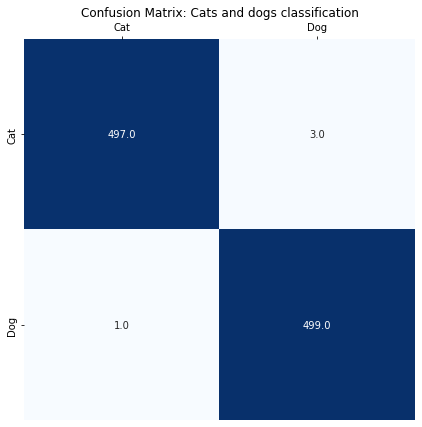

In [33]:
#definindo os argumentos:
model_matrix = confusion_matrix(test_dataset.classes, prediction)

#definindo tamanho da figura:
fig, ax = plt.subplots(figsize = (7, 7))

#plotando o heatmap:
sns.heatmap(model_matrix, cmap = "Blues", annot = True, fmt = ".1f", cbar = False)

#xticks:
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels = xticks_labels)

#yticks:
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels = yticks_labels)

#nomes dos eixos:
plt.xlabel('')
plt.ylabel('')

#definindo o título e plotando a imagem:
title = 'Confusion Matrix: Cats and dogs classification'
plt.title(title, loc = 'center')

plt.show

In [35]:
#resumindo a acurácia da rede através do classification_report do sklearn:
from sklearn.metrics import classification_report

print(classification_report(test_dataset.classes, prediction))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       500
           1       0.99      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## Salvando e carregando a nossa rede neural:

In [37]:
#realizando o salvamento dos parâmetros de nosso modelo:
model_json = network.to_json() #convertendo a rede para o formato .json

with open ('network.json', 'w') as json_file: 
  json_file.write(model_json)

In [38]:
#import do módulo necessário para realizar o salvamento dos pesos das camadas:
from keras.models import save_model

#salvando o modelo:
saved_network = save_model(network, '/content/weights.hdf5')

In [39]:
#visualizando o arquivo .json referente a nosso modelo:

with open ('network.json', 'r') as json_file:
  json_saved_model =  json_file.read()

json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "Conv1", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "bn_Conv1", "trainable": false, "dtype": "float32", "axis

In [41]:
#carregamento do modelo salvo:
loaded_network = tf.keras.models.model_from_json(json_saved_model) #pegando o modelo do .json
loaded_network.load_weights('weights.hdf5') #pesos das camadas
loaded_network.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy']) #compilando o modelo

In [42]:
#visualizando as informações concernentes às camadas:
loaded_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

## Testando nosso modelo:

In [64]:
#carregando uma única imagem para realizar o teste:
img_test1 = cv2.imread('/content/drive/MyDrive/colab_notebooks/cat_dog/test_set/dog/dog.3500.jpg', cv2.IMREAD_UNCHANGED)

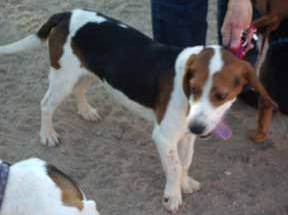

In [65]:
#visualizando a imagem:
from google.colab.patches import cv2_imshow

cv2_imshow(img_test1)

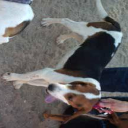

In [66]:
#realizando alterações no tamanho e na rotação da imagem, para tornar a classificação mais difícil:
img_test1 = cv2.resize(img_test1, (128, 128))
img_test1 = cv2.rotate(img_test1, cv2.ROTATE_90_CLOCKWISE)

#Visualizando as alterações:
cv2_imshow(img_test1)

In [67]:
#normalizando a imagem:
img_test1 = img_test1 / 255

#visualizando as alterações:
img_test1

array([[[0.65882353, 0.65098039, 0.63529412],
        [0.65882353, 0.63529412, 0.62352941],
        [0.62745098, 0.58823529, 0.58039216],
        ...,
        [0.45098039, 0.4745098 , 0.45490196],
        [0.4627451 , 0.48627451, 0.46666667],
        [0.4627451 , 0.48627451, 0.46666667]],

       [[0.7254902 , 0.71764706, 0.70588235],
        [0.74901961, 0.7254902 , 0.71372549],
        [0.75686275, 0.7254902 , 0.71372549],
        ...,
        [0.48627451, 0.50980392, 0.49019608],
        [0.48235294, 0.50588235, 0.48627451],
        [0.45490196, 0.47843137, 0.45882353]],

       [[0.73333333, 0.72941176, 0.70980392],
        [0.75686275, 0.7372549 , 0.7254902 ],
        [0.79215686, 0.76078431, 0.74901961],
        ...,
        [0.49019608, 0.51372549, 0.49411765],
        [0.44313725, 0.4627451 , 0.44705882],
        [0.41960784, 0.44313725, 0.42352941]],

       ...,

       [[0.31372549, 0.30196078, 0.3372549 ],
        [0.31764706, 0.30196078, 0.3372549 ],
        [0.30980392, 0

In [68]:
#visualizando o formato:
img_test1.shape

(128, 128, 3)

In [69]:
#realizando um reshape com a finalidade de tornar o formato compreensível ao modelo:
img_test1 = img_test1.reshape(1,128,128,3)

In [70]:
#verificando as alterações do formato:
img_test1.shape

(1, 128, 128, 3)

In [71]:
#realizando a previsão para a imagem:
prediction_test = loaded_network(img_test1)

prediction_test

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.2230246, 0.7769754]], dtype=float32)>

In [72]:
#verificando os índices das classes com as quais estamos trabalhando:
test_dataset.class_indices

{'cat': 0, 'dog': 1}

In [73]:
#visualizando a previsão de nosso modelo:

prediction = np.argmax(prediction_test)

if prediction == 0:
  print('The model identified a cat (=^･ｪ･^=))ﾉ彡☆')
else:
  print('The model identified a dog （Ｕ・ω・）⊃')

The model identified a dog （Ｕ・ω・）⊃
